# High dynamic range eclipse photography 

## About this project

In this notebook and (and additional scripts), I combine several exposures of the 2017 solar eclipse into a single high dynamic range image. I use darkfield analysis to estimate the noise floor of the Canon 600-D camera I used. I use an edge detection algorithm to find a first estimate of the centre of the solar disk. I crop the images down by a factor of $\approx 10$ to dramatically speed up the calculation of the correlation between images, the peak of which allows for registration of the images to within a few pixels, which is smaller than the point spread function of the camera optics. I then adjust the images by exposure time and compute the average RGB brightness of each point in the sky around the solar eclipse, including the solar wind whose brightness varies by four orders of magnitude. 

### Remaining goals

The objective of this project is to produce a true-to-the-eye image of the solar eclipse. The remaining challenges are:
* **Enhancing the contrast:** The human eye is particularly sensitive to *local* contrast, rather than total dynamic range. This means that much more detail is visible in the solar wind than simply the combination of the images. Things to try here are gradient-based and fourier-based methods.
* **Colour recovery:** During the eclipse, stars are visible in a gently blue sky around the disk of the sun, a truly remarkable vision. Reproducing this image requires careful adjustment of the brightness levels whilst retaining as much of the global contrast as possible. Further, the bright red prominences are visible jutting out around the disk of the moon, which are washed out by the white light in the presently composed image. One way to make these visible is detailed work with image editing software, but this isn't desirable. It may be possible to enhance the visibility of these coronal mass ejections using the contrast enhancement methods above.
* **Deblurring:** The camera optics have an intrinsic point spread function and spherical aberration. Worse, I also failed to ensure these images were perfectly focused, and the tripod I used was a lightweight aluminum one, which tended to 

Some [inspiration](https://upload.wikimedia.org/wikipedia/commons/c/cd/Total_Solar_Eclipse_8-21-17.jpg)


## Set things up

In [3]:
import numpy as np
import scipy as scp
import skimage as ski
from skimage import feature
import matplotlib.pyplot as plt
import skimage.io as io
import os
from tqdm import tqdm, tqdm_notebook
from mpl_toolkits.mplot3d import Axes3D  
# Axes3D import has side effects, it enables using projection='3d' in add_subplot
import matplotlib.pyplot as plt
from eclipse_init import *
import pyvips
import time

# Set things up

exposure_times={"65": 1/1250,
"66": 1/800,
"67": 1/640,
"68": 1/500,
"69": 1/400,
"70": 1/320,
"71": 1/250,
"72": 1/160,
"73": 1/100,
"74": 1/60,
"75": 1/40,
"76": 1/25,
"77": 1/20,
"78": 1/15,
"79": 1/13,
"80": 1/10,
"81": 1/8,
"83": 1/6,
"84": 1/5,
"85": 1/4,
"86": 1/3,
"87": 1/2,
"88": 0.6,
"89": 0.8,
"90": 1}

data_root = "C:\\Users\\jaker\\Pictures\\Oregon_Eclipse\\16bit\\registered\\"
out_root = "C:\\Users\\jaker\\Pictures\\Oregon_Eclipse\\output\\"
dir_files=os.listdir(data_root)
img_fnames = [fn for fn in dir_files if fn[0:3] == 'IMG']
img_paths = [data_root+fn for fn in img_fnames]
num_imgs = len(img_paths)
img_tags = [fname[6:8] for fname in img_fnames]
all_exp = np.r_[[exposure_times[tag] for tag in img_tags]]



In [1]:
# Optional: Scale notebook to span browser window
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# Centering by optimization

In [ ]:
data_root = "C:\\Users\\jaker\\Pictures\\Oregon_Eclipse\\8bit\\"
dir_files=os.listdir(data_root)
img_paths = [data_root+fn for fn in dir_files if fn[0:3] == 'IMG']
img_paths=img_paths[2:]
img_imports = io.imread_collection(img_paths)
num_imgs = len(img_imports)

## Single image processing
# show the edges of the lunar disk and zoom
winsize = 600;
sm_sigma = 0.1
reopt_cutoff = 350 
opt_verbose = False
visual_out = True

def cost_fn(x,pts):
    return np.var(np.sqrt(np.sum((x.reshape(2,1)-pts)**2,axis=0)))

im_cens = np.zeros([num_imgs,2])
edge_seps = np.zeros([num_imgs,2,2])
disk_radii = np.zeros([num_imgs,2])

for im_idx in np.r_[0:num_imgs]:
    print('Starting img %u/%u'%(im_idx,num_imgs))
    filename = img_paths[im_idx][-12:]
    this_img = img_imports[im_idx]
    im_greyscale = ski.color.rgb2gray(this_img) 
    
    # Detect the edges of the lunar disk
    edges = feature.canny(im_greyscale,sigma=sm_sigma)
    edge_pts = np.nonzero(edges)
    my = int(np.mean(edge_pts[0]))+np.r_[-winsize,winsize]
    mx = int(np.mean(edge_pts[1]))+np.r_[-winsize,winsize]
    print('Edges detected')
    
    # Find the centre by minimizing the variance of the radius function
    x0 = np.mean(edge_pts,axis=1)
    opt_res=scp.optimize.minimize(lambda x: cost_fn(x,edge_pts),x0,
                                  method='nelder-mead',options={'xtol': 1e-8, 'disp': opt_verbose})

    R = np.sqrt(np.sum((opt_res.x.reshape(2,1)-edge_pts)**2,axis=0))
    print('Centre optimized')
#     # Cull points too far from disk (noise etc) and recentre
#     R_mask = R<reopt_cutoff
#     trim_pts=[edge_pts[0][R_mask],edge_pts[1][R_mask]]

#     opt_res2=scp.optimize.minimize(lambda x: cost_fn(x,trim_pts),x0,
#                                    method='nelder-mead',options={'xtol': 1e-8, 'disp': opt_verbose})

#     R2 = np.sqrt(np.sum((opt_res.x.reshape(2,1)-trim_pts)**2,axis=0))

    # Done! Write calculations for outputs
    cen_disk = np.int_(opt_res.x)
    ysep = [-cen_disk[0]+im_greyscale.shape[0],cen_disk[0]]
    xsep = [-cen_disk[1]+im_greyscale.shape[1],cen_disk[1]]
    
    [ymin,ymax] = [cen_disk[0]-min(ysep),cen_disk[0]+min(ysep)]
    [xmin,xmax] = [cen_disk[1]-min(xsep),cen_disk[1]+min(xsep)]

    ## Write the Outputs
    im_cens[im_idx] = cen_disk
    edge_seps[im_idx] = [ysep,xsep]
    disk_radii[im_idx] = [np.mean(R),np.std(R)]
    
    img_crop = this_img[ymin:ymax,xmin:xmax]
    out_fname = data_root+'\\crop\\'+filename
    io.imsave(out_fname, img_crop)
    
    ## Visual/verbose out
    if visual_out:
        theta = np.r_[0:2*np.pi:0.01]
        X = np.cos(theta)
        Y = np.sin(theta)
        r2=np.median(R)
        arc2 = [r2*X,r2*Y]+opt_res2.x.reshape(2,1)

        plt.figure()
        plt.subplot(1,3,1)
        plt.imshow(edges[my[0]:my[1],mx[0]:mx[1]],extent=[mx[0],mx[1],my[1],my[0]])
        plt.subplot(1,3,2)
        plt.imshow(this_img[my[0]:my[1],mx[0]:mx[1]],extent=[mx[0],mx[1],my[1],my[0]])
        plt.plot(opt_res.x[1],opt_res.x[0],'o')
        plt.plot(arc2[1],arc2[0],linewidth=3,linestyle='dotted')
        plt.subplot(1,3,3)
        plt.hist(R2,500)
        plt.show()
        
        plt.figure()
        plt.imshow(img_crop,extent=[xmin,xmax,ymax,ymin])
        plt.show()
    print('img %u of %u:'%(im_idx,num_imgs))
    print('Disk radius        (%.2f +- %.2f)'%(np.mean(R),np.std(R)))
    print('Disk centre (Y,X)  (%u,%u)'%(cen_disk[0],cen_disk[1]))
    print('Dist to edge (X)  (%u,%u)'%(xsep[0],xsep[1]))
    print('Dist to edge (Y)  (%u,%u)'%(ysep[0],ysep[1]))

In [ ]:
x_pts = np.r_[0:disk_radii.shape[0]]
plt.subplot(2,2,1)
plt.errorbar(x_pts,disk_radii[:,0],disk_radii[:,1],fmt='x')
plt.ylim([0,350])
plt.subplot(2,2,2)
plt.plot(im_cens[:,1],im_cens[:,0],'.')
plt.xlim([0,5194])
plt.ylim([0,3457])
plt.subplot(2,2,3)
plt.plot(edge_seps[:,0])
plt.subplot(2,2,4)
plt.plot(edge_seps[:,1])
plt.show()

Try using a Sobel filter for the edge detection?
vs canny vs Hough (parametrizes circles?)

# Pixel registration

In [ ]:
data_root = "C:\\Users\\jaker\\Pictures\\Oregon_Eclipse\\converted\\"
dir_files=os.listdir("C:\\Users\\jaker\\Pictures\\Oregon_Eclipse\\converted\\")
crop_files = [fn for fn in dir_files if fn[0:4] == 'crop']
crop_tags = [fname[11:13] for fname in crop_files]
crop_paths = [data_root+fn for fn in dir_files if fn[0:4] == 'crop']
crop_imgs = io.imread_collection(crop_paths)
num_imgs = len(crop_imgs)
all_sizes=np.r_[[img.shape for img in crop_imgs]]
grey_imgs = [ski.color.rgb2gray(img) for img in crop_imgs]
print('%u images imported'%(num_imgs))

In [ ]:
frame_pad = 800
blank_dim = np.r_[max(all_sizes[:,0]),max(all_sizes[:,1])]
frame_size = blank_dim + np.r_[frame_pad,frame_pad]
img_array = crop_imgs

[rgb_sum,n_sum]=channel_registration(img_array,grey_imgs,frame_size,sigma=5,mask_level=0.4,verbose=2,subsampwidth=700,img_names = crop_tags)

In [ ]:
r_sum = rgb_sum[0]
g_sum = rgb_sum[1]
b_sum = rgb_sum[2]
zoom_range = [1000,3000,2000,4000]

rhist=np.histogram(r_sum,300)
rcounts = rhist[0]
ghist=np.histogram(g_sum,300)
gcounts = ghist[0]
bhist=np.histogram(b_sum,300)
bcounts = bhist[0]

hist_bins = 0.5*(rhist[1][1:]+rhist[1][:-1])


plt.figure(figsize=(9,9))
plt.subplot(221)
plt.imshow(r_sum[zoom_range[0]:zoom_range[1],zoom_range[2]:zoom_range[3]])
plt.subplot(222)
plt.imshow(g_sum[zoom_range[0]:zoom_range[1],zoom_range[2]:zoom_range[3]])
plt.subplot(223)
plt.imshow(b_sum[zoom_range[0]:zoom_range[1],zoom_range[2]:zoom_range[3]])
plt.subplot(224)
plt.imshow(n_sum)

plt.show()

plt.figure(figsize=(7,7))
plt.subplot(2,1,1)
plt.plot(hist_bins[1:],rcounts[1:],color='red')
plt.plot(hist_bins[1:],gcounts[1:],color='green')
plt.plot(hist_bins[1:],bcounts[1:],color='blue')
plt.subplot(2,1,2)
plt.plot(hist_bins[1:],rcounts[1:],color='red')
plt.plot(hist_bins[1:],gcounts[1:],color='green')
plt.plot(hist_bins[1:],bcounts[1:],color='blue')
plt.yscale('log')
plt.show()

# Dark Field analysis

In [146]:
dark_root = "C:\\Users\\jaker\\Pictures\\Oregon_Eclipse\\darkfield\\png\\"
dark_files=os.listdir(dark_root)
dark_fnames = [fn for fn in dark_files if fn[-3:] == 'png']
dark_paths = [dark_root+fn for fn in dark_fnames]
num_dark_imgs = len(dark_paths)

dark_raw = "C:\\Users\\jaker\\Pictures\\Oregon_Eclipse\\darkfield\\raw\\"
raw_files=os.listdir(dark_raw)
raw_fnames = [fn for fn in raw_files if fn[-3:] == 'CR2']
raw_paths = [dark_raw+fn for fn in raw_fnames]

dark_exp = 1/np.r_[100,100,60,60,40,40,25,25,15,15,13,13,10,10,8,8,6,6,5,5,4,4,2,2,1,1]

Means:  [648.7366132725406, 209.5165807903002, 255.7611522228815]
 Stds:  [893.8587986051681, 327.2444309230728, 374.3489367021995]


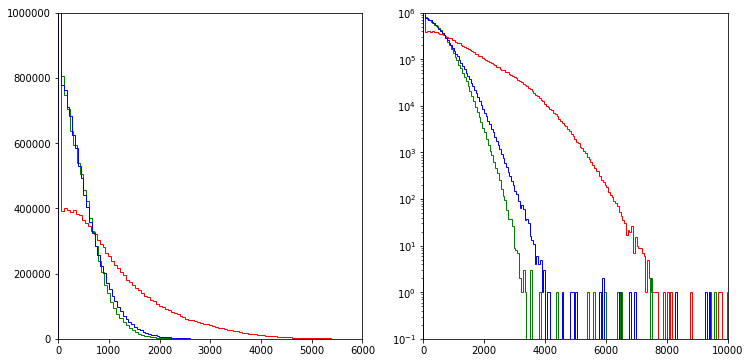

Means:  [712.3882328344637, 212.79656184139841, 264.0303039855181]
 Stds:  [933.9834788148733, 330.8132100101501, 382.4600855291221]


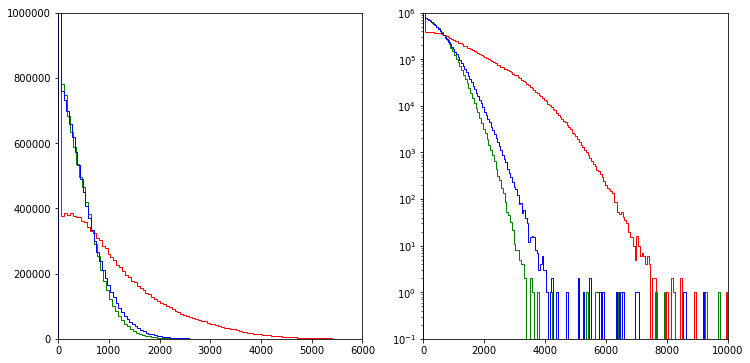

Means:  [440.55516690059477, 209.1210190125029, 212.00555808091244]
 Stds:  [658.7950696303694, 322.0289626204759, 329.80705215064626]


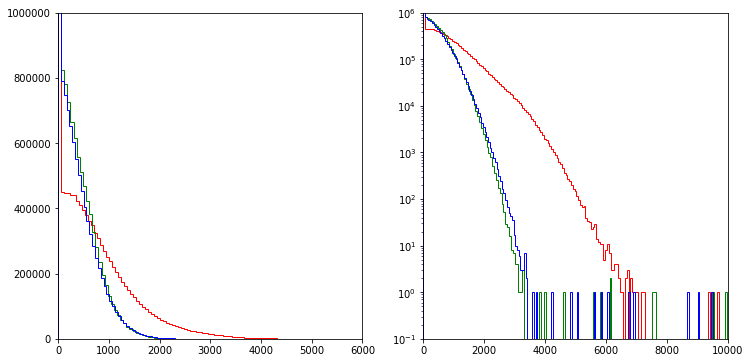

Means:  [663.2934566363427, 218.1629440703315, 262.8959695601242]
 Stds:  [985.2272533523397, 355.3071664545558, 427.96250912117387]


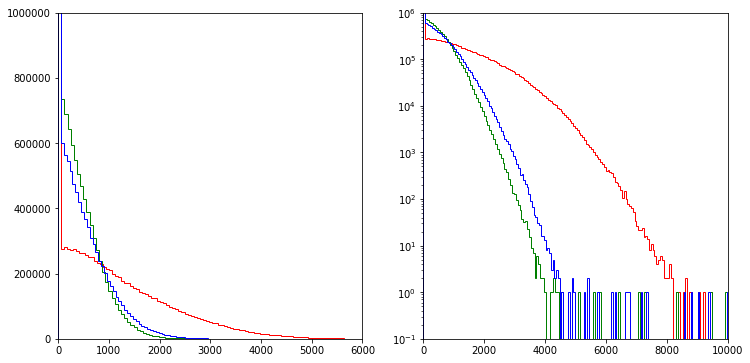

Means:  [646.3173716050952, 217.14231937364812, 264.93755767680585]
 Stds:  [972.6743090531168, 354.08612106323244, 428.88531725854904]


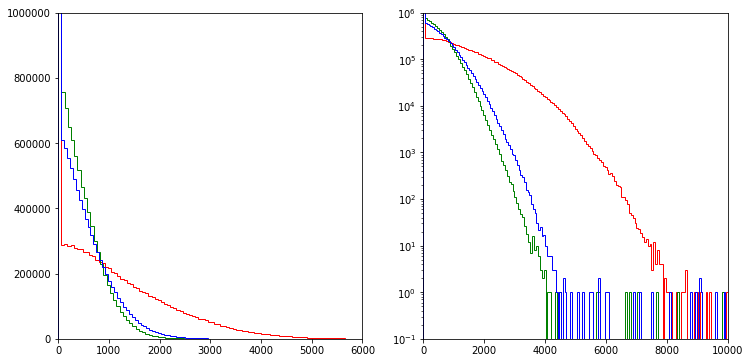

Means:  [633.3828682301702, 209.84615356340603, 252.28203349607128]
 Stds:  [879.0439724028593, 327.14404348047515, 369.93269108508105]


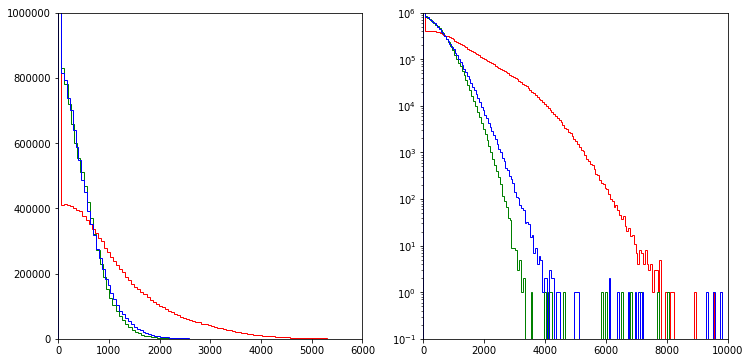

Means:  [582.0233294151626, 209.97990839433453, 268.33317737506474]
 Stds:  [828.8456680544307, 325.19354112154235, 384.5350821417915]


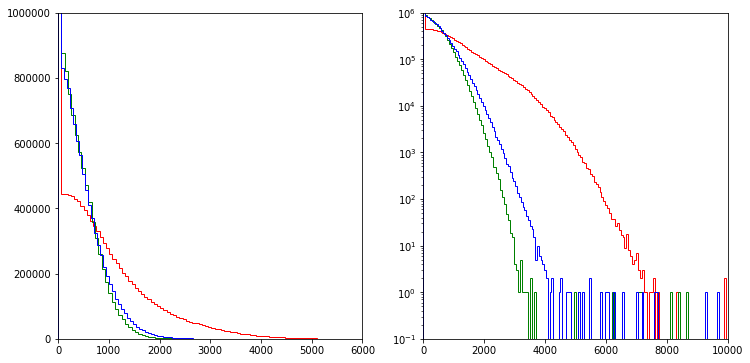

Means:  [1583.1139312744763, 257.1111042547146, 222.93518717052865]
 Stds:  [2309.493735351795, 444.1545609858904, 398.30265983855077]


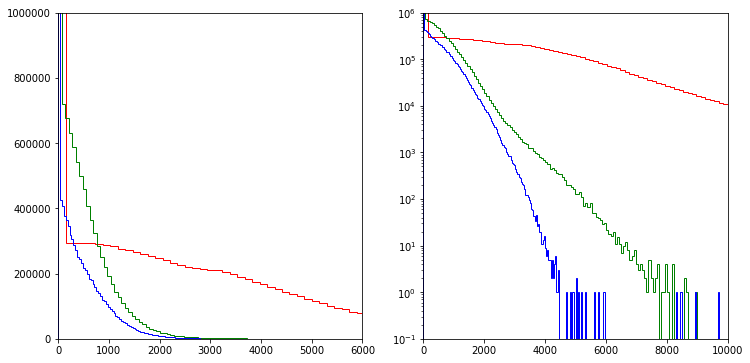

Means:  [676.1273356286915, 211.09032194754434, 245.3220052977173]
 Stds:  [910.8169409869831, 328.6720289028351, 361.1174229299993]


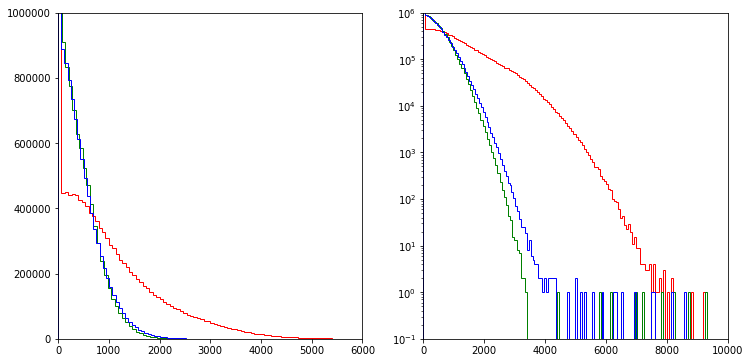

Means:  [646.1791746089172, 217.17008555186337, 263.20560844943697]
 Stds:  [974.610895563537, 354.7301499381907, 427.9743908536267]


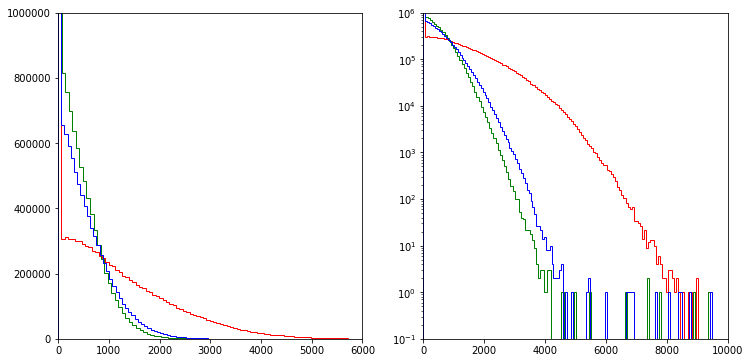

Means:  [670.6035980413527, 210.49890647282322, 257.1395081706279]
 Stds:  [904.8517835266239, 327.7120797811039, 375.33647540462374]


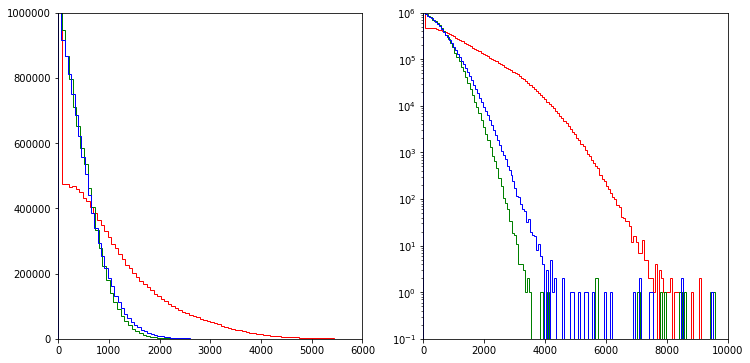

Means:  [659.2024820811356, 212.10933250120937, 238.73888821005613]
 Stds:  [897.464905501837, 329.7781112485089, 355.33712004265084]


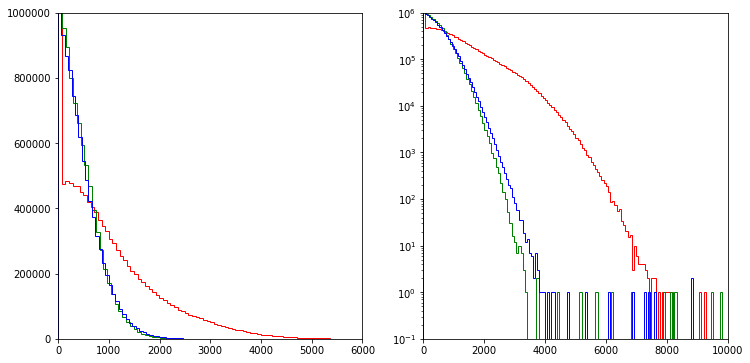

Means:  [472.42402639880976, 213.95822559106438, 214.74267431469235]
 Stds:  [683.5956174544482, 325.78180683143665, 327.6329456532051]


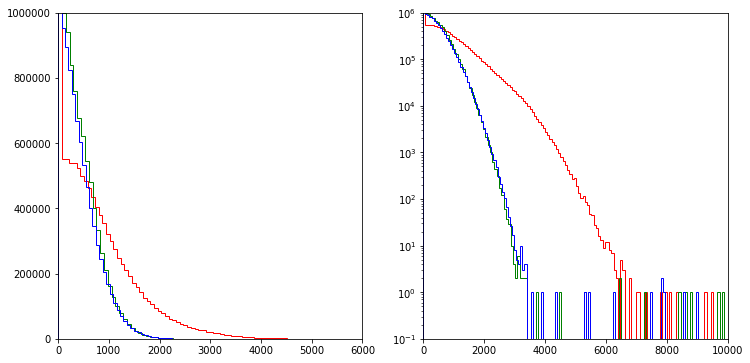

Means:  [701.0893925469064, 231.6007677914115, 273.83183323050594]
 Stds:  [938.2166804574825, 346.29616952593267, 394.1926582891051]


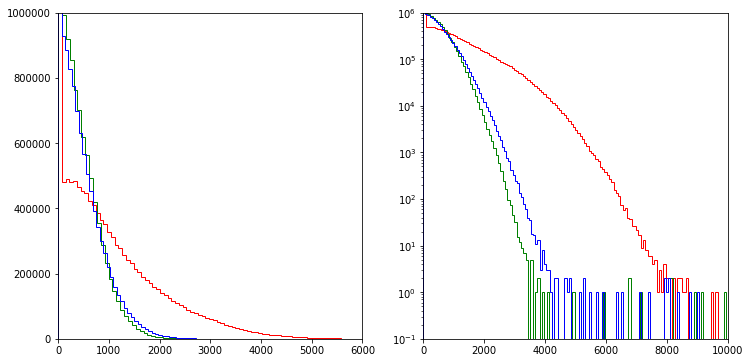

Means:  [760.6701716528573, 215.67511416178678, 282.742268871461]
 Stds:  [969.649187141979, 335.15261620622886, 398.826707901695]


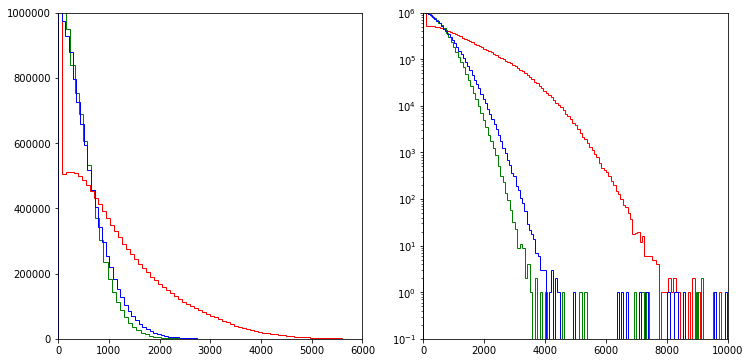

Means:  [574.6691655633005, 211.76450253173678, 233.13530431466228]
 Stds:  [860.8209633907688, 335.5457813935741, 372.60947492524735]


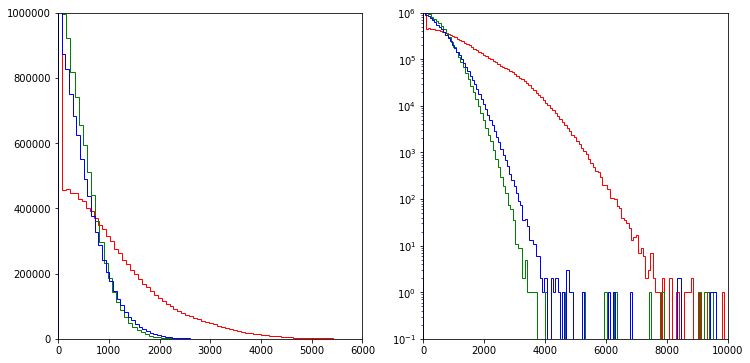

Means:  [665.9228056693885, 211.01798201992932, 253.06468902448464]
 Stds:  [898.247706934419, 328.31647193651423, 369.0455425943284]


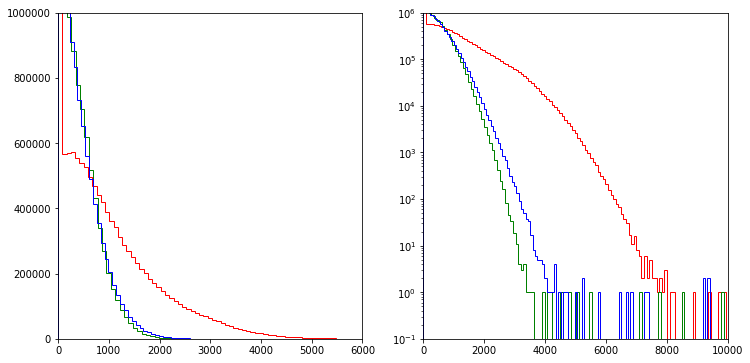

Means:  [583.4578220413866, 208.40893499976443, 245.4379742028947]
 Stds:  [838.2583478306076, 325.93493137374435, 362.8500356922754]


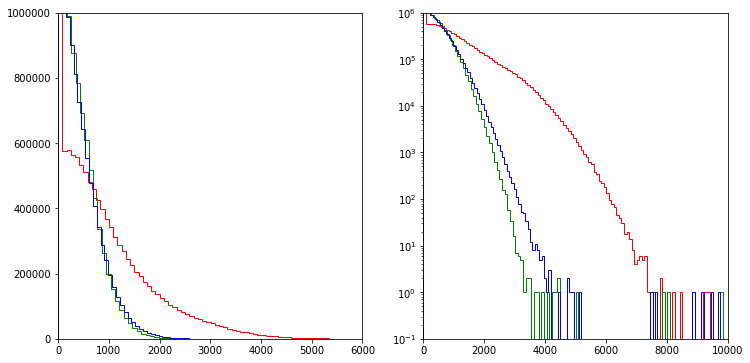

Means:  [589.2163519710612, 209.29214685421164, 231.07625122955673]
 Stds:  [836.8803550621112, 325.6718233589924, 347.0878753544818]


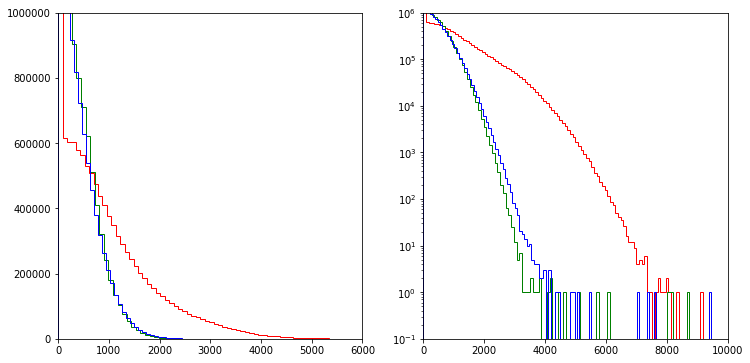

Means:  [814.3613498319025, 215.64650418269272, 267.24040511353024]
 Stds:  [1003.7140888226687, 336.40290001767676, 387.22067578263204]


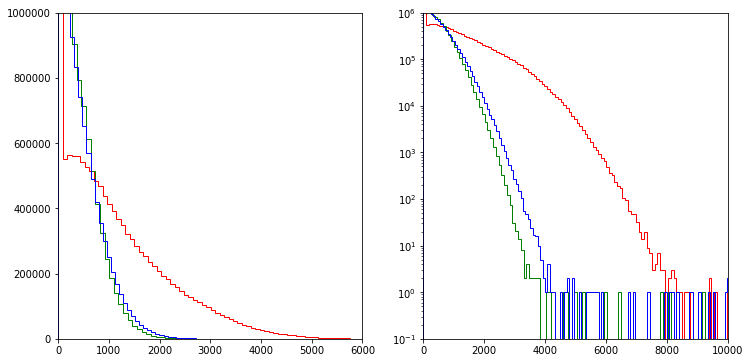

Means:  [649.8388774168009, 215.51800886383558, 259.1972320368321]
 Stds:  [976.797597161913, 353.7849843429985, 425.43068671040686]


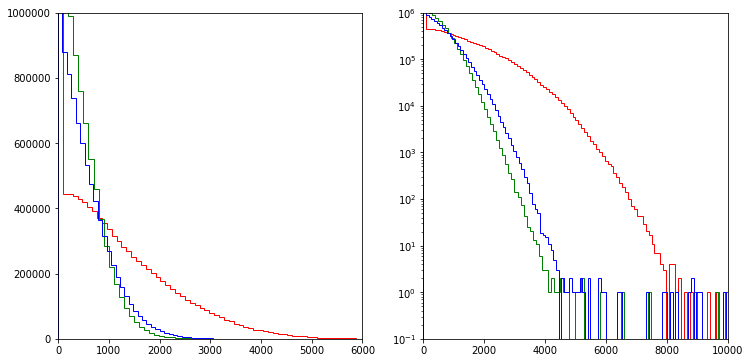

Means:  [667.4562586901577, 217.08034665173506, 257.9739088369805]
 Stds:  [988.4393093334904, 354.99177065977335, 424.78370207416583]


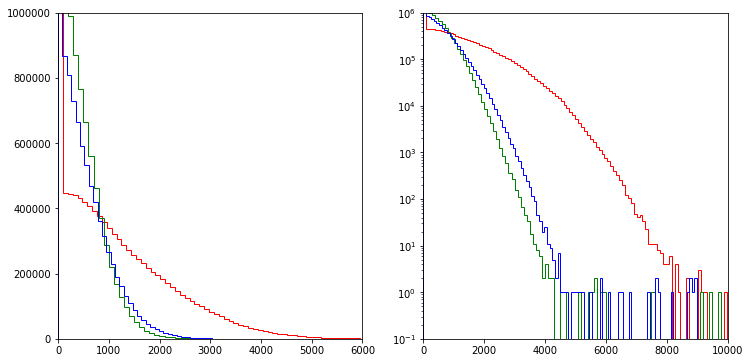

Means:  [507.5641498072641, 209.81876425804055, 216.39676641201342]
 Stds:  [741.1341324026125, 324.6037841586135, 332.65550462715987]


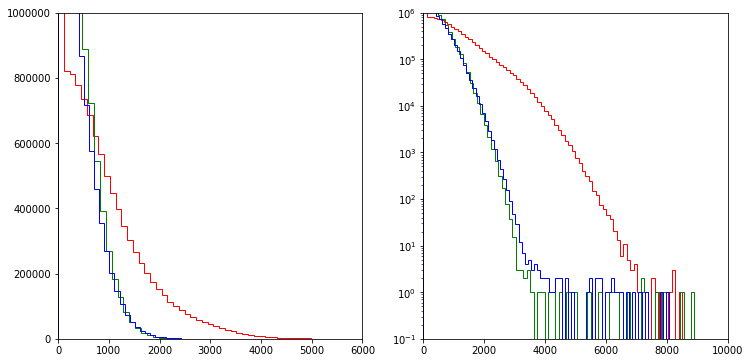

Means:  [2168.5148839992385, 290.4116409434842, 223.1615661202725]
 Stds:  [3159.8138425962184, 530.8324150762536, 403.8008287561833]


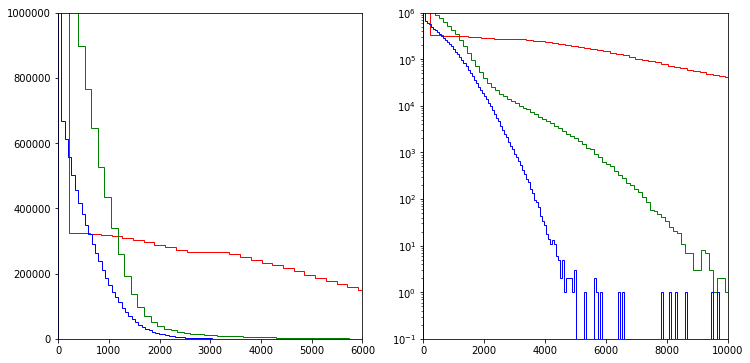

Means:  [566.5227034286352, 212.34074925018064, 290.28766425602447]
 Stds:  [831.2545660223896, 329.65787086120554, 407.57026298997624]


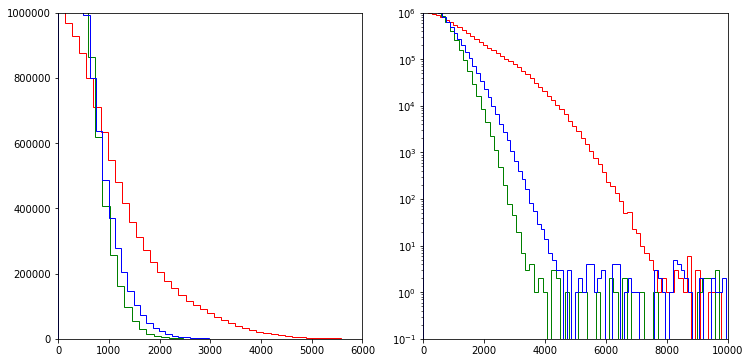

Means:  [567.7476285190996, 215.68743668430307, 315.91056663030673]
 Stds:  [822.8972459761661, 332.15602014325793, 426.27195911603815]


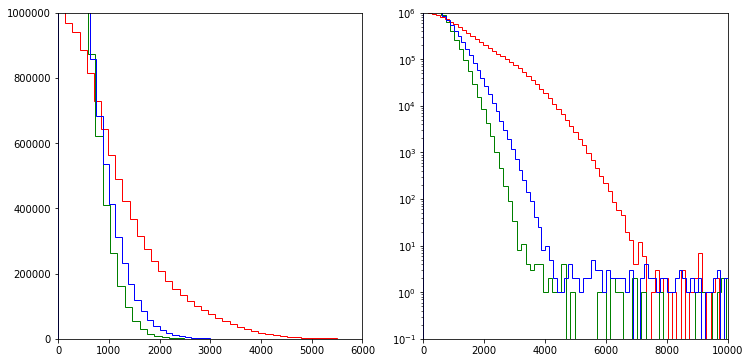

In [138]:
means = np.zeros([num_dark_imgs,3])
stds = np.zeros([num_dark_imgs,3])
for im_idx in np.r_[0:num_dark_imgs]:
    dark_img = get_img_with_vips(dark_paths[im_idx])
    [means[im_idx],stds[im_idx]]=show_darkfield(dark_img)
    

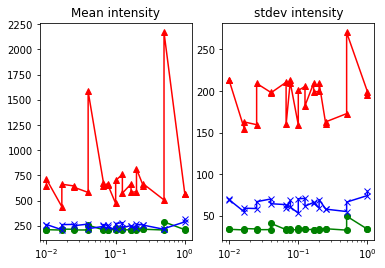

In [183]:
plt.figure()
plt.subplot(121)
plt.plot(dark_exp,means[:,0],color='r',marker='^')
plt.plot(dark_exp,means[:,1],color='g',marker='o')
plt.plot(dark_exp,means[:,2],color='b',marker='x')
plt.title('Mean intensity')
plt.xscale('log')
plt.subplot(122)
plt.plot(dark_exp,stds[:,0],color='r',marker='^')
plt.plot(dark_exp,stds[:,1],color='g',marker='o')
plt.plot(dark_exp,stds[:,2],color='b',marker='x')
plt.title('stdev intensity')
plt.xscale('log')
plt.show()

Well, something weird happened in a couple of those, but it does look like this fixes our noise floor pretty well:

In [194]:
smeans = np.copy(means)
smeans[smeans>1e3] = np.nan
sstds = np.copy(stds)
sstds[sstds>1.5e3] = np.nan
noise_level = np.nanmean(smeans,axis=0)
noise_std = np.nanmean(sstds,axis=0)
print('Mean noise levels: ',noise_level)
print('noise variance:    ',noise_std)


Mean noise levels:  [628.15629107 217.18334989 251.76106425]
noise variance:     [193.35665065  34.69773851  64.33101507]


It looks like our dark count level can be set after smoothing at the $\approx 3\sigma$ level  pretty safely. We could then zero all the pixels below this level. However, we'd still have image noise on the remaining pixels, and we'd be sacrificing dynamic range. 
But, instead we could subtract off the mean noise level from each channel. This would add a variance equal to the noise variance. However, the averaging effect saves us here, as we'll end up combining about 20 images. Therefore the final uncertainty would be the $\sqrt{\sigma^2_{img}+\sigma^2_{dark}}/\sqrt{20}$.
If the image variance is much larger, then we won't care about the sensor noise; if the sensor noise dominates, it will be crushed by a factor of 5 by averaging the images.

# Smoothing

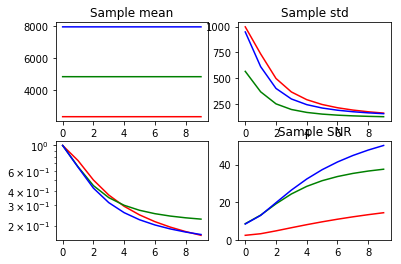

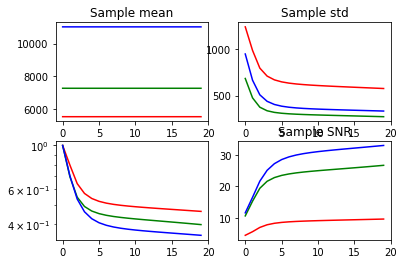

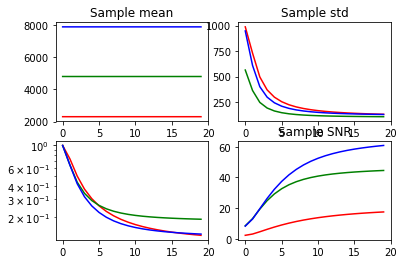

In [134]:
# Check the noise bandwidth
kmax = 20
im_num = 15
test_img = get_img_with_vips(img_paths[im_num])

im_centre = [3000,600]
sample_size = [250,250]
rgn = np.int_([im_centre[0]+sample_size[0]*np.r_[-1,1],
      im_centre[1]+sample_size[1]*np.r_[-1,1]])
sample=test_img[rgn[0][0]:rgn[0][1],rgn[1][0]:rgn[1][1]]
examine_smoothing(sample)

im_centre = [3310,2600] ## Middle of disk
sample_size = [130,130]
rgn = np.int_([im_centre[0]+sample_size[0]*np.r_[-1,1],
      im_centre[1]+sample_size[1]*np.r_[-1,1]])
sample=test_img[rgn[0][0]:rgn[0][1],rgn[1][0]:rgn[1][1]]
examine_smoothing(sample,kmax=kmax)

im_centre = [2000,1000]
sample_size = [250,250]
rgn = np.int_([im_centre[0]+sample_size[0]*np.r_[-1,1],
      im_centre[1]+sample_size[1]*np.r_[-1,1]])
sample=test_img[rgn[0][0]:rgn[0][1],rgn[1][0]:rgn[1][1]]
examine_smoothing(sample,kmax=kmax)

Let's check the lowest exposure:

Inspect the smoothing visually:

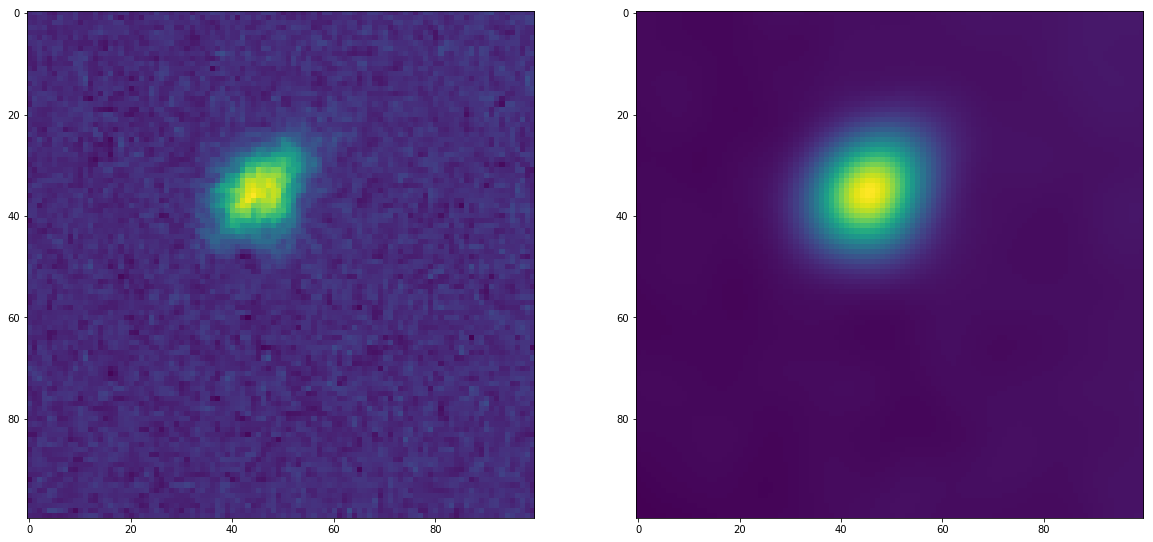

In [135]:
 # Inspect the smoothing
sigma=5 # seems just on the good side of the elbow
test_image = get_img_with_vips(img_paths[15])
smooth_test = rgb_filter(test_image,sigma)
rgn = np.r_[4150,4250,1400,1500]
plt.figure(figsize=(20,20))
plt.subplot(121)
imshow16(test_image[rgn[0]:rgn[1],rgn[2]:rgn[3]])
plt.subplot(122)
imshow16(smooth_test[rgn[0]:rgn[1],rgn[2]:rgn[3]])
plt.show()


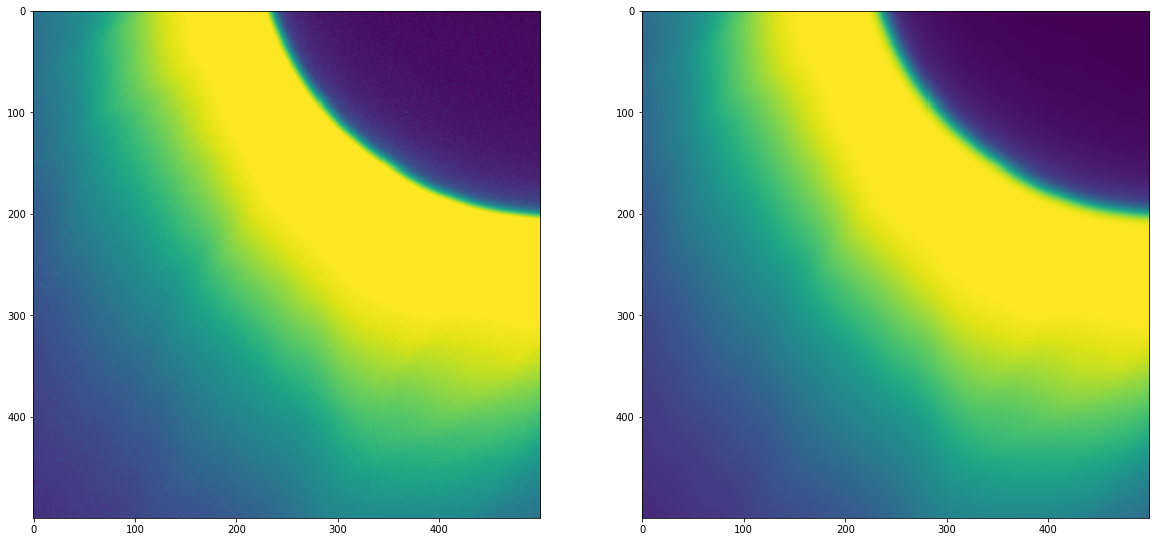

In [121]:
# Inspect the smoothing
rgn = np.r_[3400,3900,2100,2600]
plt.figure(figsize=(20,20))
plt.subplot(121)
imshow16(test_image[rgn[0]:rgn[1],rgn[2]:rgn[3]])
plt.subplot(122)
imshow16(smooth_test[rgn[0]:rgn[1],rgn[2]:rgn[3]])
plt.show()


# Exposure correction

Naively, one assumes that the pixel intensity is proportional to the current obtained from the sensor, which would be proportional to the number of photons (the electric field intensity). Assuming constant gain, the pixel brightness is therefore $g\cdot I\cdot T$, where $g$ is the sensor gain, $I$ is the light intensity, and $T$ is the exposure time. Indeed, we see this below; the pixel brightness is linear with exposure time.


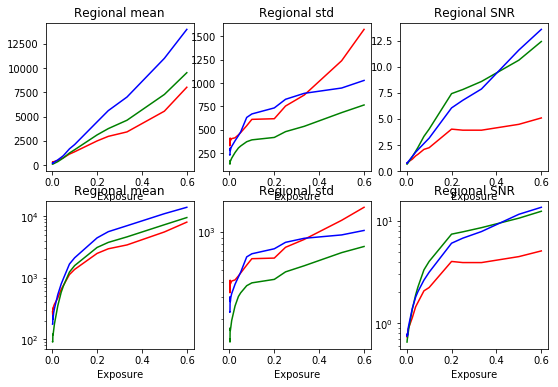

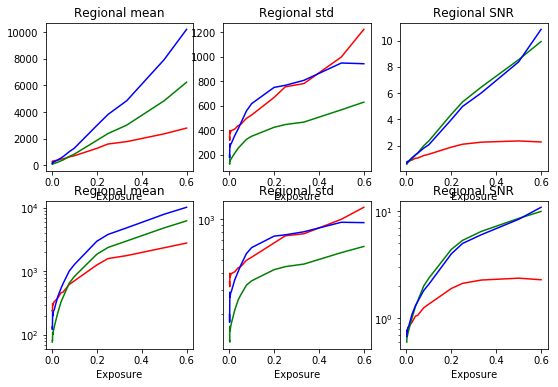

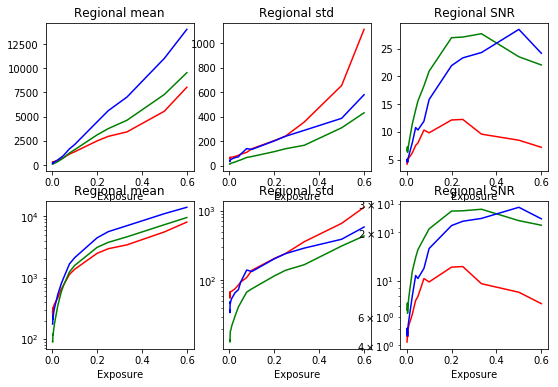

In [38]:
im_centre = [3310,2600] ## Middle of disk
sample_size = [130,130]
rgn = np.int_([im_centre[0]+sample_size[0]*np.r_[-1,1],
      im_centre[1]+sample_size[1]*np.r_[-1,1]])
out = exposure_scaling(img_paths,rgn,all_exp)

im_centre = [3000,600]
sample_size = [250,250]
rgn = np.int_([im_centre[0]+sample_size[0]*np.r_[-1,1],
      im_centre[1]+sample_size[1]*np.r_[-1,1]])
out = exposure_scaling(img_paths,rgn,all_exp)

# im_centre = [2000,1000]
# sample_size = [250,250]
# rgn = np.int_([im_centre[0]+sample_size[0]*np.r_[-1,1],
#       im_centre[1]+sample_size[1]*np.r_[-1,1]])
# out = exposure_scaling(img_paths,rgn)

# Smoothed
im_centre = [3310,2600] ## Middle of disk
sample_size = [130,130]
rgn = np.int_([im_centre[0]+sample_size[0]*np.r_[-1,1],
      im_centre[1]+sample_size[1]*np.r_[-1,1]])
out = exposure_scaling(img_paths,rgn,all_exp,sigma=5)

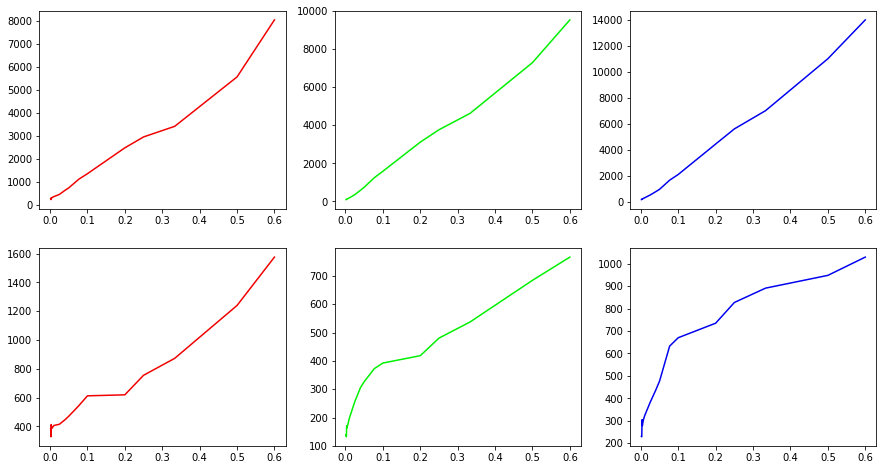

In [92]:
# Looking at the noise scaling in the lunar disk
im_centre = [3310,2600] 
sample_size = [130,130]
rgn = np.int_([im_centre[0]+sample_size[0]*np.r_[-1,1],
      im_centre[1]+sample_size[1]*np.r_[-1,1]])
nbins = 300
[mns,stds] = [np.zeros([num_imgs,3]),np.zeros([num_imgs,3])]
for im_idx in np.r_[0:num_imgs]:
    test_img = get_img_with_vips(img_paths[im_idx])
    sample = test_img[rgn[0][0]:rgn[0][1],rgn[1][0]:rgn[1][1]]
    [mns[im_idx],stds[im_idx]] = channel_stats(sample)
    
plt.figure(figsize=(15,8))
bins = 0.5*(e[1:]+e[:-1])
plt.subplot(231)
plt.plot(all_exp,mns[:,0],color=[idx/num_imgs,0,0])
plt.subplot(232)
plt.plot(all_exp,mns[:,1],color=[0,idx/num_imgs,0])
plt.subplot(233)
plt.plot(all_exp,mns[:,2],color=[0,0,idx/num_imgs])
plt.subplot(234)
plt.plot(all_exp,stds[:,0],color=[idx/num_imgs,0,0])
plt.subplot(235)
plt.plot(all_exp,stds[:,1],color=[0,idx/num_imgs,0])
plt.subplot(236)
plt.plot(all_exp,stds[:,2],color=[0,0,idx/num_imgs])
plt.show()

In [105]:
# Looking at the noise scaling in the lunar disk
im_centre = [3000,600]
sample_size = [250,250]
rgn = np.int_([im_centre[0]+sample_size[0]*np.r_[-1,1],
      im_centre[1]+sample_size[1]*np.r_[-1,1]])
nbins = 300
allcounts = np.zeros([num_imgs,3,nbins])
for im_idx in np.r_[0:num_imgs]:
    test_img = get_img_with_vips(img_paths[im_idx])
    sample = test_img[rgn[0][0]:rgn[0][1],rgn[1][0]:rgn[1][1]]
    [allcounts[im_idx,0],e]=scp.histogram(sample[:,:,0],nbins)
    [allcounts[im_idx,1],e]=scp.histogram(sample[:,:,1],nbins)
    [allcounts[im_idx,2],e]=scp.histogram(sample[:,:,2],nbins)

C:\Users\jaker\Pictures\Oregon_Eclipse\16bit\registered\IMG_0567.png
C:\Users\jaker\Pictures\Oregon_Eclipse\16bit\registered\IMG_0568.png
C:\Users\jaker\Pictures\Oregon_Eclipse\16bit\registered\IMG_0569.png
C:\Users\jaker\Pictures\Oregon_Eclipse\16bit\registered\IMG_0570.png
C:\Users\jaker\Pictures\Oregon_Eclipse\16bit\registered\IMG_0571.png
C:\Users\jaker\Pictures\Oregon_Eclipse\16bit\registered\IMG_0572.png
C:\Users\jaker\Pictures\Oregon_Eclipse\16bit\registered\IMG_0573.png
C:\Users\jaker\Pictures\Oregon_Eclipse\16bit\registered\IMG_0575.png
C:\Users\jaker\Pictures\Oregon_Eclipse\16bit\registered\IMG_0576.png
C:\Users\jaker\Pictures\Oregon_Eclipse\16bit\registered\IMG_0577.png
C:\Users\jaker\Pictures\Oregon_Eclipse\16bit\registered\IMG_0579.png
C:\Users\jaker\Pictures\Oregon_Eclipse\16bit\registered\IMG_0580.png
C:\Users\jaker\Pictures\Oregon_Eclipse\16bit\registered\IMG_0584.png
C:\Users\jaker\Pictures\Oregon_Eclipse\16bit\registered\IMG_0585.png
C:\Users\jaker\Pictures\Oregon_Ecl

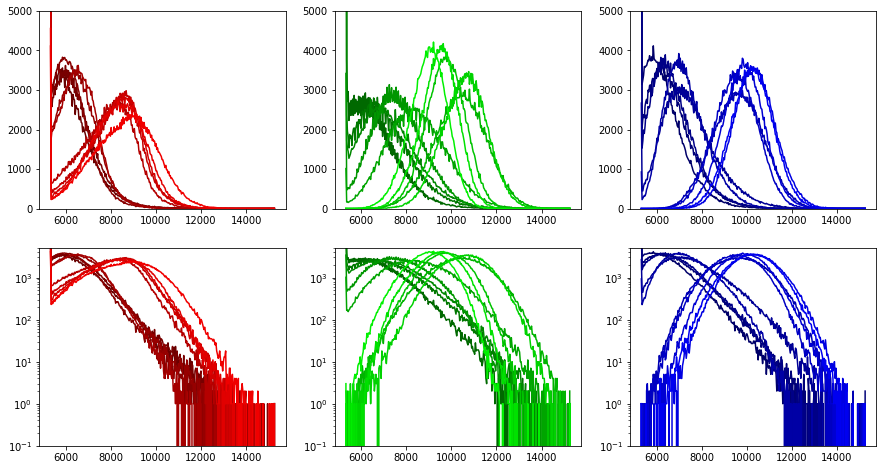

In [117]:
ymax = 5e3
min_imx = 7
plt.figure(figsize=(15,8))
bins = 0.5*(e[1:]+e[:-1])
plt.subplot(231)
for idx in np.r_[min_imx:num_imgs]:
    plt.plot(bins,allcounts[idx,0,:],color=[idx/num_imgs,0,0])
plt.ylim([0,ymax])
plt.subplot(232)
for idx in np.r_[min_imx:num_imgs]:
    plt.plot(bins,allcounts[idx,1,:],color=[0,idx/num_imgs,0])
plt.ylim([0,ymax])
plt.subplot(233)
for idx in np.r_[min_imx:num_imgs]:
    plt.plot(bins,allcounts[idx,2,:],color=[0,0,idx/num_imgs])
plt.ylim([0,ymax])
plt.subplot(234)
for idx in np.r_[min_imx:num_imgs]:
    plt.plot(bins,allcounts[idx,0,:],color=[idx/num_imgs,0,0])
plt.ylim([0.1,ymax])
plt.yscale('log')
plt.subplot(235)
for idx in np.r_[min_imx:num_imgs]:
    plt.plot(bins,allcounts[idx,1,:],color=[0,idx/num_imgs,0])
plt.ylim([0.1,ymax])
plt.yscale('log')
plt.subplot(236)
for idx in np.r_[min_imx:num_imgs]:
    plt.plot(bins,allcounts[idx,2,:],color=[0,0,idx/num_imgs])
plt.ylim([0.1,ymax])
plt.yscale('log')
plt.show()

The intensity scaling makes good sense, and the proportions are roughly even across the exposures. linear scaling of the SNR  is puzzling; for Poissonian statistics it should scale with $1/\sqrt(T)$. But also, why is it that the mean of the regional values scales correctly (linear), but the histograms suggest a trend with a maximum followed by a dip?
Why is it that the shorter exposures fail to scale correctly with exposure time? Is it an artefact of the noise?

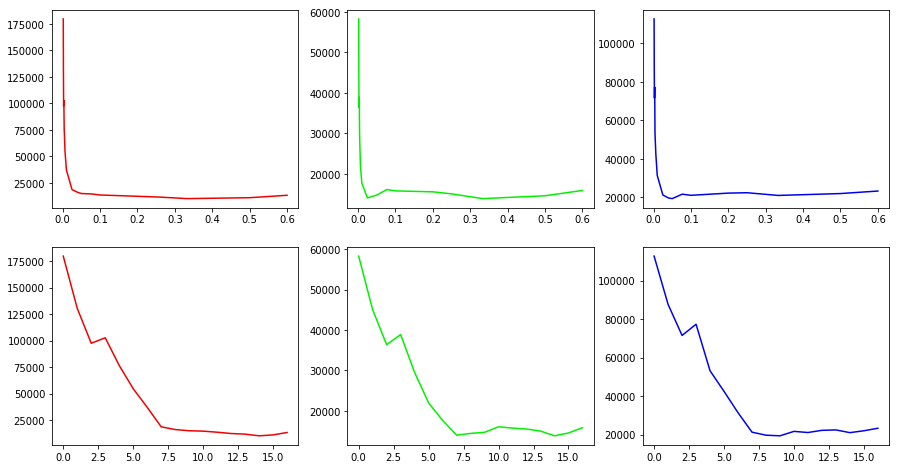

In [106]:
im_centre = [3310,2600] 
sample_size = [130,130]
rgn = np.int_([im_centre[0]+sample_size[0]*np.r_[-1,1],
      im_centre[1]+sample_size[1]*np.r_[-1,1]])
nbins = 300
[mns,stds] = [np.zeros([num_imgs,3]),np.zeros([num_imgs,3])]
for im_idx in np.r_[0:num_imgs]:
    test_img = get_img_with_vips(img_paths[im_idx])
    sample = test_img[rgn[0][0]:rgn[0][1],rgn[1][0]:rgn[1][1]]
    [mns[im_idx],stds[im_idx]] = channel_stats(sample/all_exp[im_idx])
    


So, the first six images behave badly. This is probably because most of the image is below the noise floor, so for the most part it's just amplified noise. That's a shame, but we still have images 7-16 (and possibly some more if I can fix the registration et cetera). Moreover, these exposure-corrected images behave relatively nicely under exposure-correction. So these will do for the flux estimation as we move on...

# Flux estimation

So the exposures range over a factor of 24, and the 16 bit image depth gives a total dynamic range of 1e6. The noise level reduces this to about (1e3-1e6), so only about a dynamic range of three decades.

Given each pixel is the sum of two random variables, the actual intensity and the shot noise, we can estimate the underlying signal by subtracting the noise level, setting negative values to zero, scaling by exposure time, smoothing, and taking a mean. 

In [2]:
noise_level=np.r_[628.15629107 ,217.18334989, 251.76106425]
noise_std= np.r_[193.35665065,  34.69773851,  64.33101507]
noise_floor = noise_level+0*noise_std
print('Noise floor:    ',noise_floor)
print('% of dyn range: ',100*noise_floor/2**16)


Noise floor:     [628.15629107 217.18334989 251.76106425]
% of dyn range:  [0.95849043 0.33139549 0.3841569 ]


In [6]:
t=np.zeros([3,3])
t[1][1]=1
t[1][2]=1
v=np.nonzero(t)
r = np.zeros([3,3])
r[v]=1
np.array_equal(r,t)

True

In [25]:
str(np.int(time.time()))

'1563448198'

In [29]:
im_counter = np.zeros([this_img.shape[0],this_img.shape[1],3])
im_counter[signal_px]+=1

In [34]:
idx_min = 7
idx_max = num_imgs
sum_img_paths = img_paths[idx_min:idx_max]
sum_exp = all_exp[idx_min:idx_max]
num_sum_imgs = len(sum_img_paths)
for idx in np.r_[0:num_sum_imgs]:
    print('%u/%u'%(idx+1,num_sum_imgs))
    this_img = get_img_with_vips(sum_img_paths[idx])
    if idx==0:
        # Initialize
        im_counter = np.zeros([this_img.shape[0],this_img.shape[1],3])
        mean_img = np.zeros(this_img.shape)
    c_img = this_img-dark_level
    c_img[c_img<0]=0
    this_img = c_img/sum_exp[idx]
    mean_img+=this_img

    signal_px=np.nonzero(this_img)
    im_counter[signal_px]+=1
mean_img = mean_img/num_sum_imgs
timestamp = str(np.int(time.time()))
print('Saving...')
np.save(out_root+"levels_mean_full",mean_img)
np.save(out_root+"levels_counter_full",im_counter)
print('Done!')

1/10
2/10
3/10
4/10
5/10
6/10
7/10
8/10
9/10
10/10


In [38]:
# Crop and smooth the image
cnr = [1350,4500,300,5200]
crop_im_counter = im_counter[cnr[0]:cnr[1],cnr[2]:cnr[3],:]
num_zeros=np.sum(np.ndarray.flatten(crop_im_counter==0))
print('%u empty pixels in crop region'%num_zeros)


0 empty pixels in crop region


In [42]:
crop_mean_img = mean_img[cnr[0]:cnr[1],cnr[2]:cnr[3]]
crop_mean_img = crop_mean_img/crop_im_counter.reshape(crop_mean_img.shape[0],crop_mean_img.shape[1],3)
np.save(out_root+"levels_mean_crop",crop_mean_img)
print("Array cropped and saved!")

Array cropped and saved!


From the investigation above, we conclude that a smoothing window of 5 pixels is appropriate.
We will need to mask out regions which are saturated, and pick a safe threshold of 98% of maximum value
We also want to avoid sampling regions below the noise floor. A reasonable guess is $3\sigma_0$, where $\sigma_0$ is the  

In [ ]:
im_centre = [3000,600]
sample_size = [250,250]
im_centre = [2000,1000]
sample_size = [250,250]
im_centre = [3310,2600] ## Middle of disk
sample_size = [130,130]

# Deblurring: Deconvolution

In [3]:
# Look at the raw data
crop_mean_img = np.load(out_root+"levels_mean_crop.npy")
star_rgn = np.r_[2500,3000,1500,2000]
[midx,midy] = disk_cen[0]
[midx,midy] = disk_cen[1]
norm_img = crop_mean_img/np.max(np.ndarray.flatten(crop_mean_img))
scale_img = np.int_((2**16-1)*norm_img)
display_img = np.int_((2**8-1)*norm_img)
grey_master = ski.color.rgb2gray(crop_mean_img)
grey_norm = grey_master/np.max(np.ndarray.flatten(grey_master))

In [87]:
star_rgn = np.r_[2790,2880,1100,1180]
star_full =crop_mean_img[star_rgn[0]:star_rgn[1],star_rgn[2]:star_rgn[3],:] 
star_grey =grey_master[star_rgn[0]:star_rgn[1],star_rgn[2]:star_rgn[3]] 
star_peak = np.amax(star_grey)
star_cen = np.where(star_grey==star_peak)
# plt.figure(figsize=(10,10))
# plt.imshow(star_grey,extent=(star_rgn[2],star_rgn[3],star_rgn[1],star_rgn[0]))
# plt.show()
# image_diagnostic(star_full,mid_x = star_cen[0][0],mid_y = star_cen[1][0])

Well, there's one thing to try here. Assume that the star is in fact a Gaussian, with size, say, 1px. Then we have $I = U*P$, where I is the image, U is the underlying signal, and P is the point spread function. We can then get a prior for the PSF by the spectral quotient $P=I/U$. 

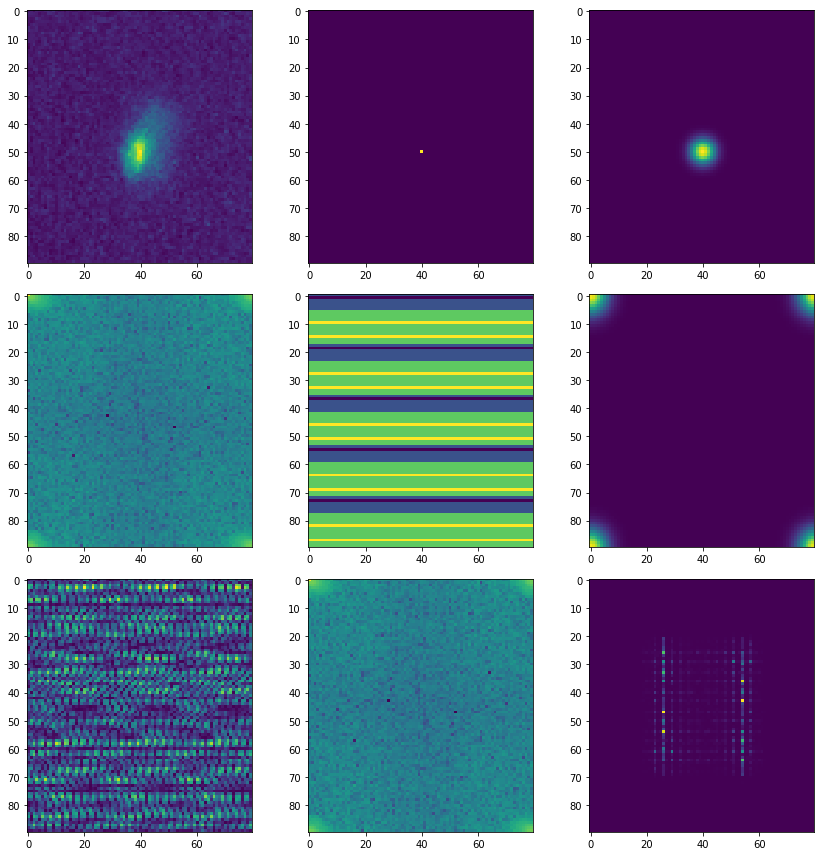

In [88]:
point_img = np.zeros(star_grey.shape)
point_img[star_cen]+=star_peak
gaus_img = scp.ndimage.gaussian_filter(point_img,3)

star_ft = np.fft.fft2(star_grey)
point_ft = np.fft.fft2(point_img)
gaus_ft = np.fft.fft2(gaus_img)

gaus_prior = star_ft/gaus_ft
point_prior = star_ft/point_ft

psf = np.fft.ifft2(gaus_prior)

plt.figure(figsize=(12,12))
plt.subplot(331)
plt.imshow(star_grey)
plt.subplot(332)
plt.imshow(point_img)
plt.subplot(333)
plt.imshow(gaus_img)

plt.subplot(334)
plt.imshow(np.log(np.abs(star_ft)))
plt.subplot(335)
plt.imshow(np.abs(point_ft))
plt.subplot(336)
plt.imshow(np.abs(gaus_ft))

plt.subplot(338)
plt.imshow(np.log(np.abs(point_prior)))
plt.subplot(339)
plt.imshow(np.abs(gaus_prior))
plt.subplot(337)
plt.imshow(np.abs(psf))


plt.tight_layout()
plt.show()


c:\users\jaker\appdata\local\programs\python\python36\lib\site-packages\skimage\restoration\deconvolution.py:380: ComplexWarning: Casting complex values to real discards the imaginary part
  psf = psf.astype(np.float)


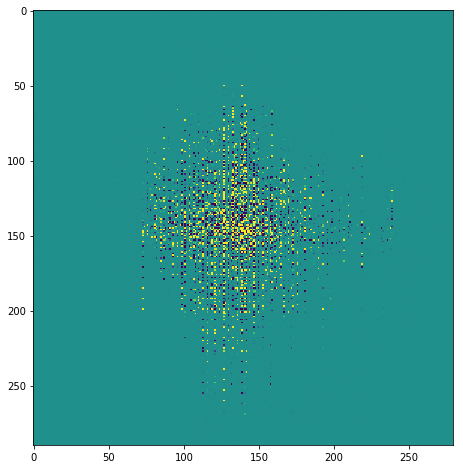

In [57]:
recover_attempt = restoration.richardson_lucy(star_grey,psf,50)
plt.figure(figsize=(8,8))
plt.imshow(recover_attempt)
plt.show()

# Deblurring: Gradient amplification

In [97]:
disk_rgn[0]

800

In [4]:
# Look at the raw data
dwidth = 1000
rgb_master = np.load(out_root+"levels_mean_crop.npy")
star_rgn = np.r_[2500,3000,1500,2000]
# disk_rgn = [[3310,2600],[1900,2300]]
disk_cen = [1800,2200]
disk_rgn = [disk_cen[0]-dwidth,disk_cen[0]+dwidth,disk_cen[1]-dwidth,disk_cen[1]+dwidth]
[midx,midy] = [disk_cen[0],disk_cen[1]]

norm_img = rgb_master/np.max(np.ndarray.flatten(rgb_master))
scale_img = np.int_((2**16-1)*norm_img)
display_img = np.int_((2**8-1)*norm_img)
grey_master = ski.color.rgb2gray(rgb_master)
grey_norm = grey_master/np.max(np.ndarray.flatten(grey_master))

In [14]:
# Attempting 16bit image save
import cv2
master_in = np.int_(rgb_rescale(rgb_master,2**16-1))
cv2.imwrite(out_root+"16bit_master_in.png",master_in.astype(np.uint16))
# Works!

True

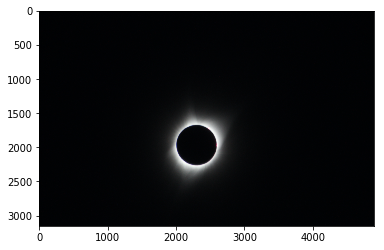

In [13]:
plt.imshow(np.int_(rgb_rescale(rgb_master,255)))
plt.show()

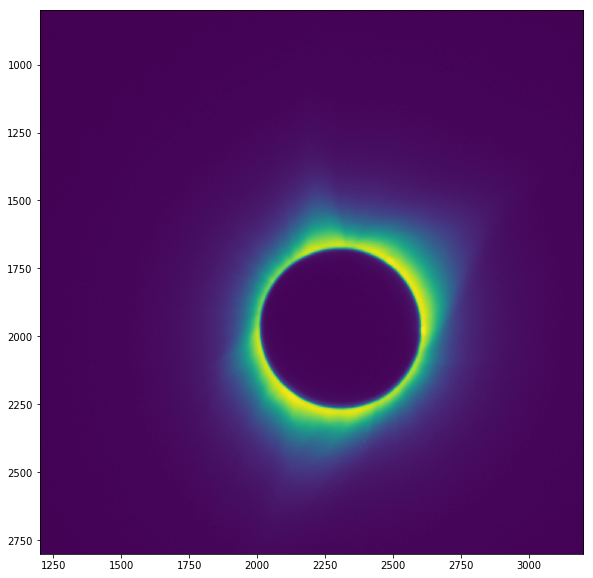

1800 2200
(3150, 4900)


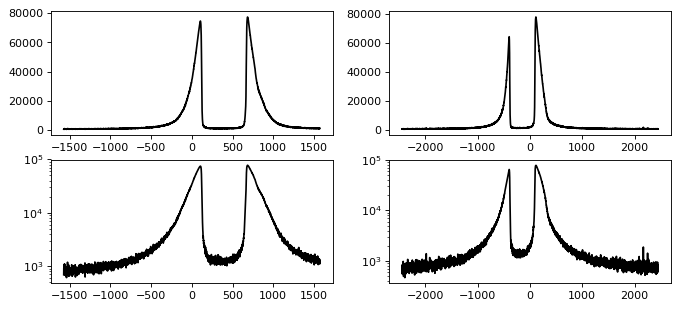

In [130]:
plt.figure(figsize=(10,10))
plt.imshow(grey_master[disk_rgn[0]:disk_rgn[1],disk_rgn[2]:disk_rgn[3]],extent=(disk_rgn[2],disk_rgn[3],disk_rgn[1],disk_rgn[0]))
plt.show()
image_diagnostic(grey_master,mid_x=midx,mid_y=midy)

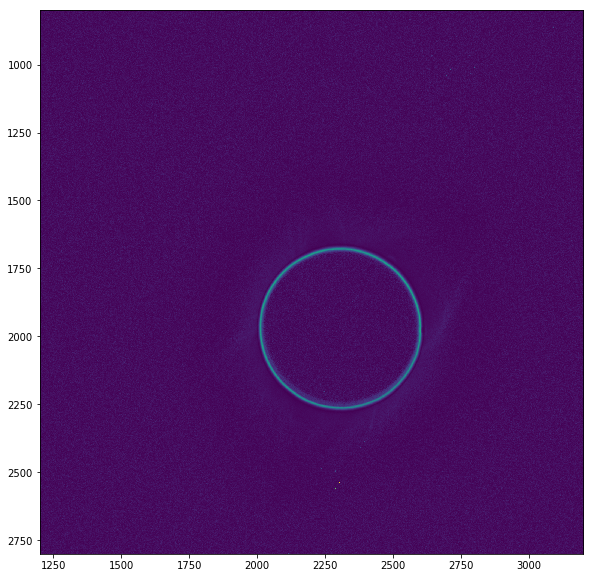

1800 2200
(3150, 4900)


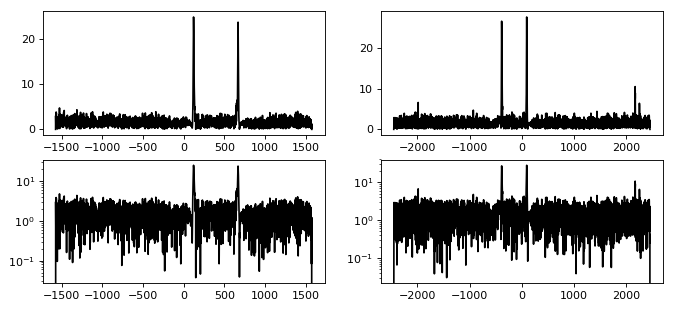

In [237]:
# Find the local gradient of lightness
im_grad = ski.filters.sobel(np.sqrt(grey_master))
plt.figure(figsize=(10,10))
plt.imshow(im_grad[disk_rgn[0]:disk_rgn[1],disk_rgn[2]:disk_rgn[3]],extent=(disk_rgn[2],disk_rgn[3],disk_rgn[1],disk_rgn[0]))
plt.show()
image_diagnostic(im_grad,mid_x=midx,mid_y=midy)

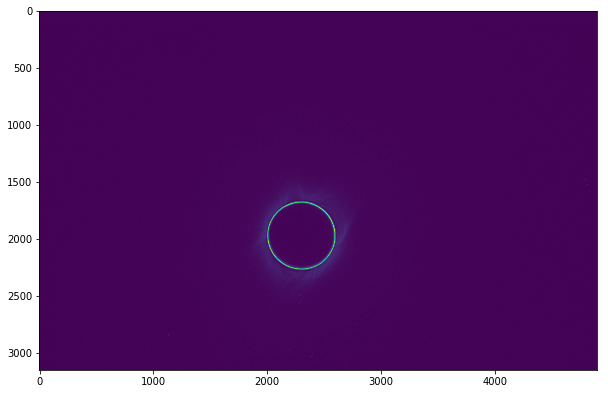

1800 2200
(3150, 4900)


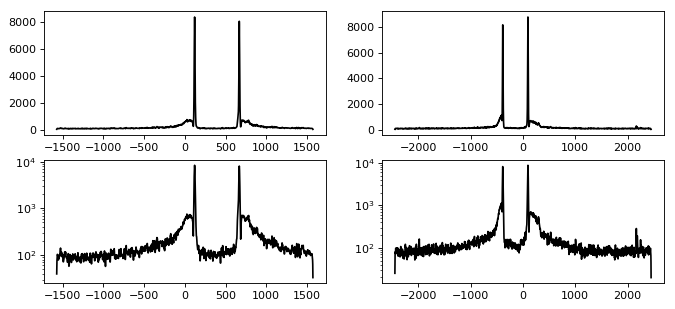

In [250]:
sm_grad = ski.filters.gaussian(im_grad,2)
plt.figure(figsize=(10,10))
plt.imshow(sm_grad)
plt.show()
image_diagnostic(sm_grad,mid_x=midx,mid_y=midy)

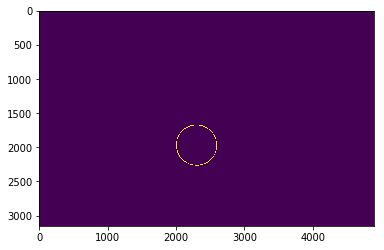

In [251]:
solar_disk = sm_grad>4e3
disk_x,disk_y=np.nonzero(solar_disk)
disk_rel = np.r_[[disk_x-disk_x[0]],[disk_y-disk_y[0]]]
disk_sep = np.sqrt(disk_rel[0]**2+disk_rel[1]**2)
disk_r=np.mean(np.sort(disk_sep)[-10:])/2+10 # cheeky correction
disk_centre = [np.mean(disk_x),np.mean(disk_y)]
coords_ = np.meshgrid(np.r_[0:grey_master.shape[1]],np.r_[0:grey_master.shape[0]])
R_vals=np.sqrt(np.r_[(coords_[0]-disk_centre[1])**2+(coords_[1]-disk_centre[0])**2])
disk_mask = R_vals <disk_r
plt.imshow(solar_disk)
plt.show()

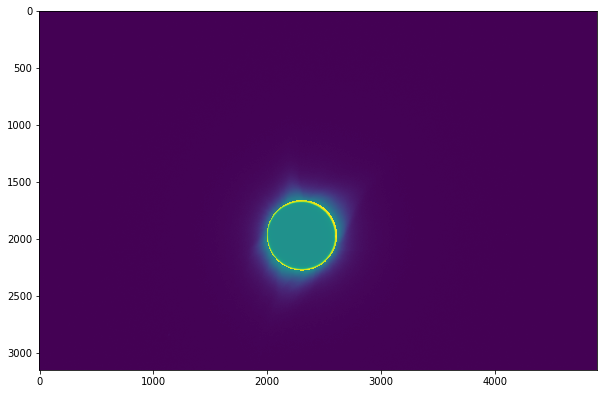

In [253]:
plt.figure(figsize=(10,10))
plt.imshow(8e4*disk_mask+grey_master)
plt.show()

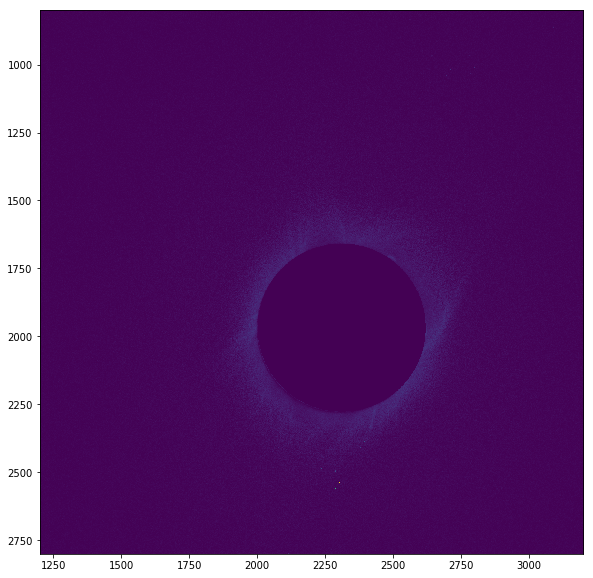

1800 2200
(3150, 4900)


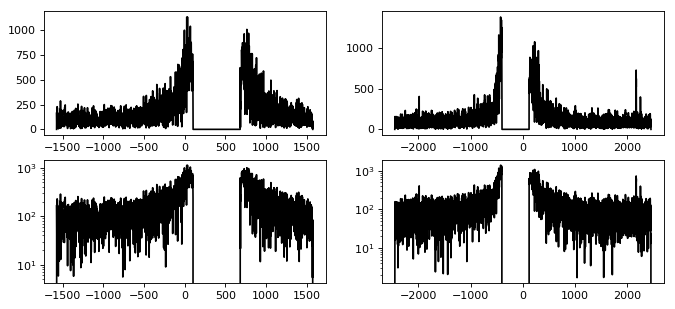

In [254]:
reg_grad = np.copy(im_grad)
reg_grad[disk_mask]=0
plt.figure(figsize=(10,10))
plt.imshow(reg_grad[disk_rgn[0]:disk_rgn[1],disk_rgn[2]:disk_rgn[3]],extent=(disk_rgn[2],disk_rgn[3],disk_rgn[1],disk_rgn[0]))
plt.show()
image_diagnostic(reg_grad,mid_x=midx,mid_y=midy)

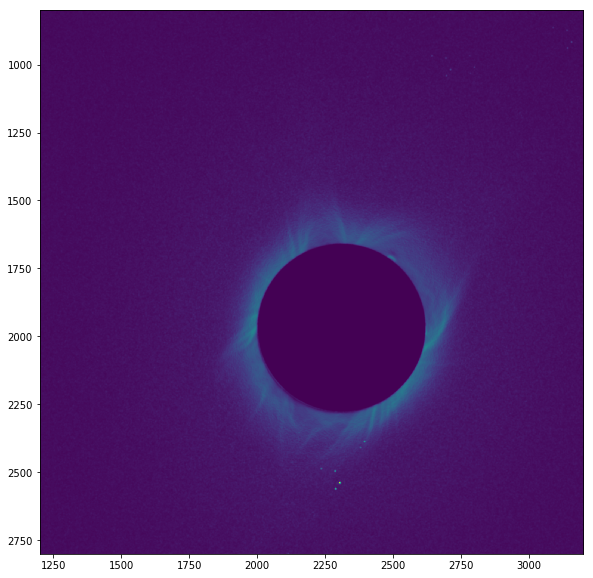

1800 2200
(3150, 4900)


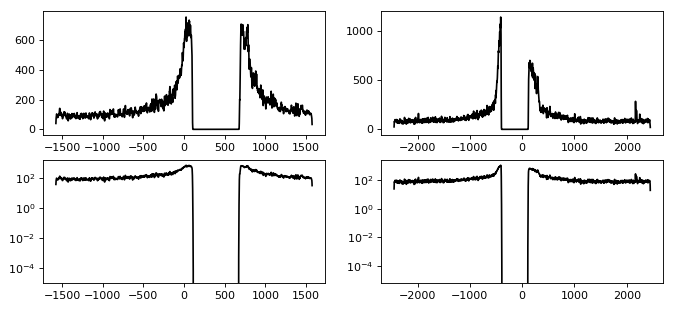

In [255]:
sm_grad = ski.filters.gaussian(reg_grad,2)
plt.figure(figsize=(10,10))
plt.imshow(sm_grad[disk_rgn[0]:disk_rgn[1],disk_rgn[2]:disk_rgn[3]],extent=(disk_rgn[2],disk_rgn[3],disk_rgn[1],disk_rgn[0]))
plt.show()
image_diagnostic(sm_grad,mid_x=midx,mid_y=midy)

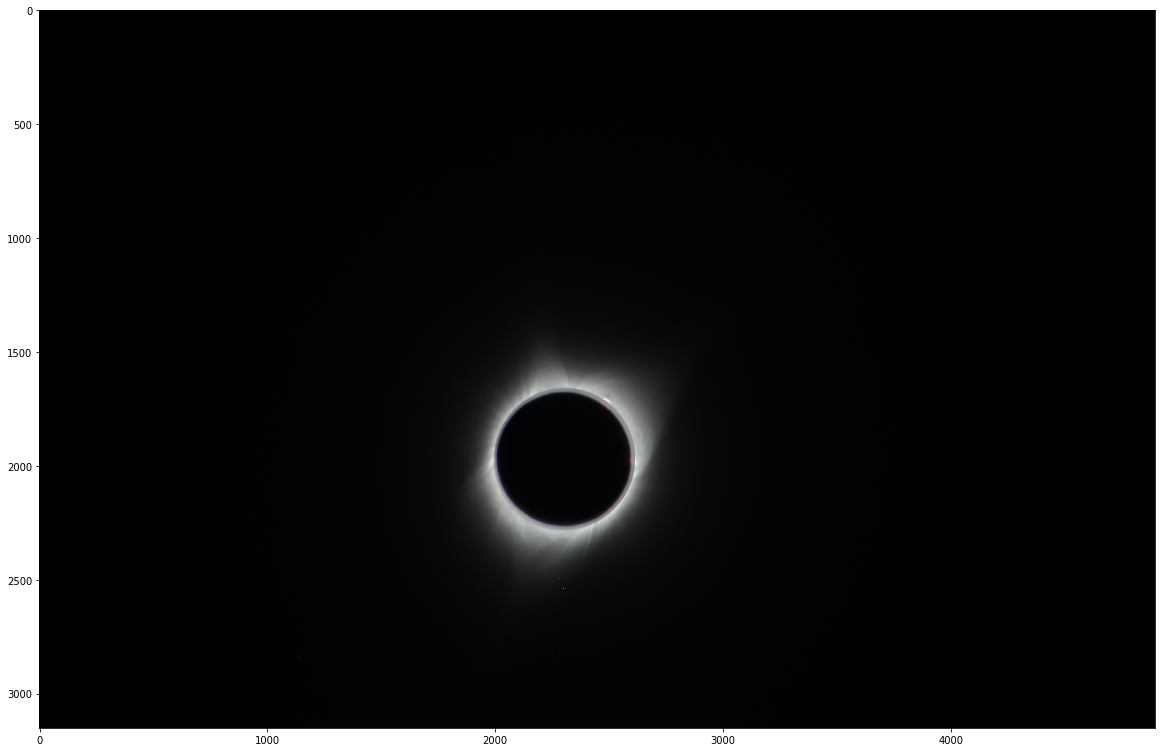

1800 2200
(3150, 4900, 3)


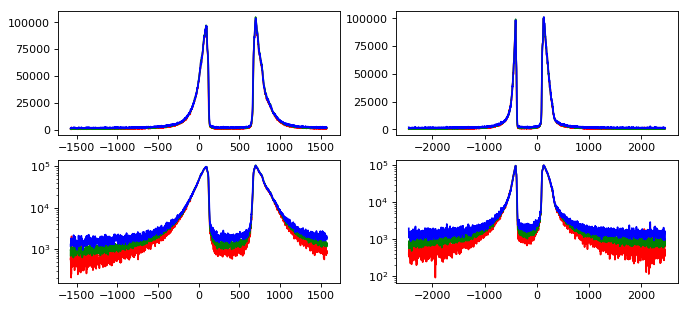

In [271]:
G = 1+2*sm_grad/np.amax(sm_grad)
rgb_test = rgb_master*G.reshape(G.shape[0],G.shape[1],1)
plt.figure(figsize=(20,20))
plt.imshow(np.int_(rgb_rescale(rgb_test,255)))
plt.show()
image_diagnostic(rgb_test,mid_x=midx,mid_y=midy)

# Mastering

This section deals with the dynamic range compression required to bring the structure into view across nearly five orders of magnitude in brightness. This range can be encoded in 16-bit colour space, but the blue of the sky and the faintness of the distal solar wind are washed out. To begin with we'll try gamma-correcting approximately by a cube-root law. There

In [49]:
# Look at the raw data
crop_mean_img = np.load(out_root+"levels_mean_crop.npy")

[midx,midy] = disk_cen[0]
[midx,midy] = disk_cen[1]

norm_img = crop_mean_img/np.max(np.ndarray.flatten(crop_mean_img))
scale_img = np.int_((2**16-1)*norm_img)
display_img = np.int_((2**8-1)*norm_img)
grey_master = ski.color.rgb2gray(crop_mean_img)
grey_norm = grey_master/np.max(np.ndarray.flatten(grey_master))



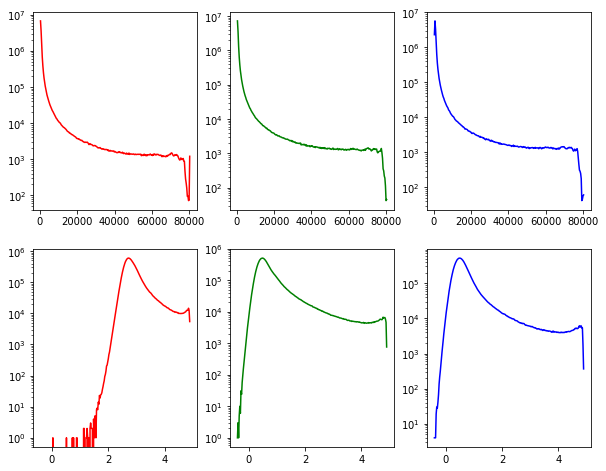

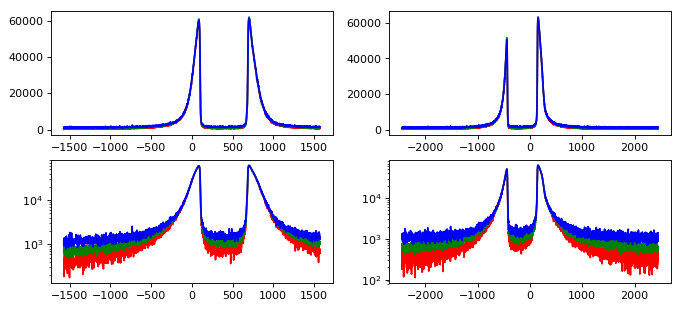

In [ ]:
[h,b]=rgb_histograms(crop_mean_img,x_log=1)
image_diagnostic(scale_img,mid_x=midx,mid_y=midy)
plt.figure(figsize=(40,40))
plt.imshow(display_img)
plt.show()

save_img_with_vips(np.int_(display_img,out_root+"master_in.jpg"))

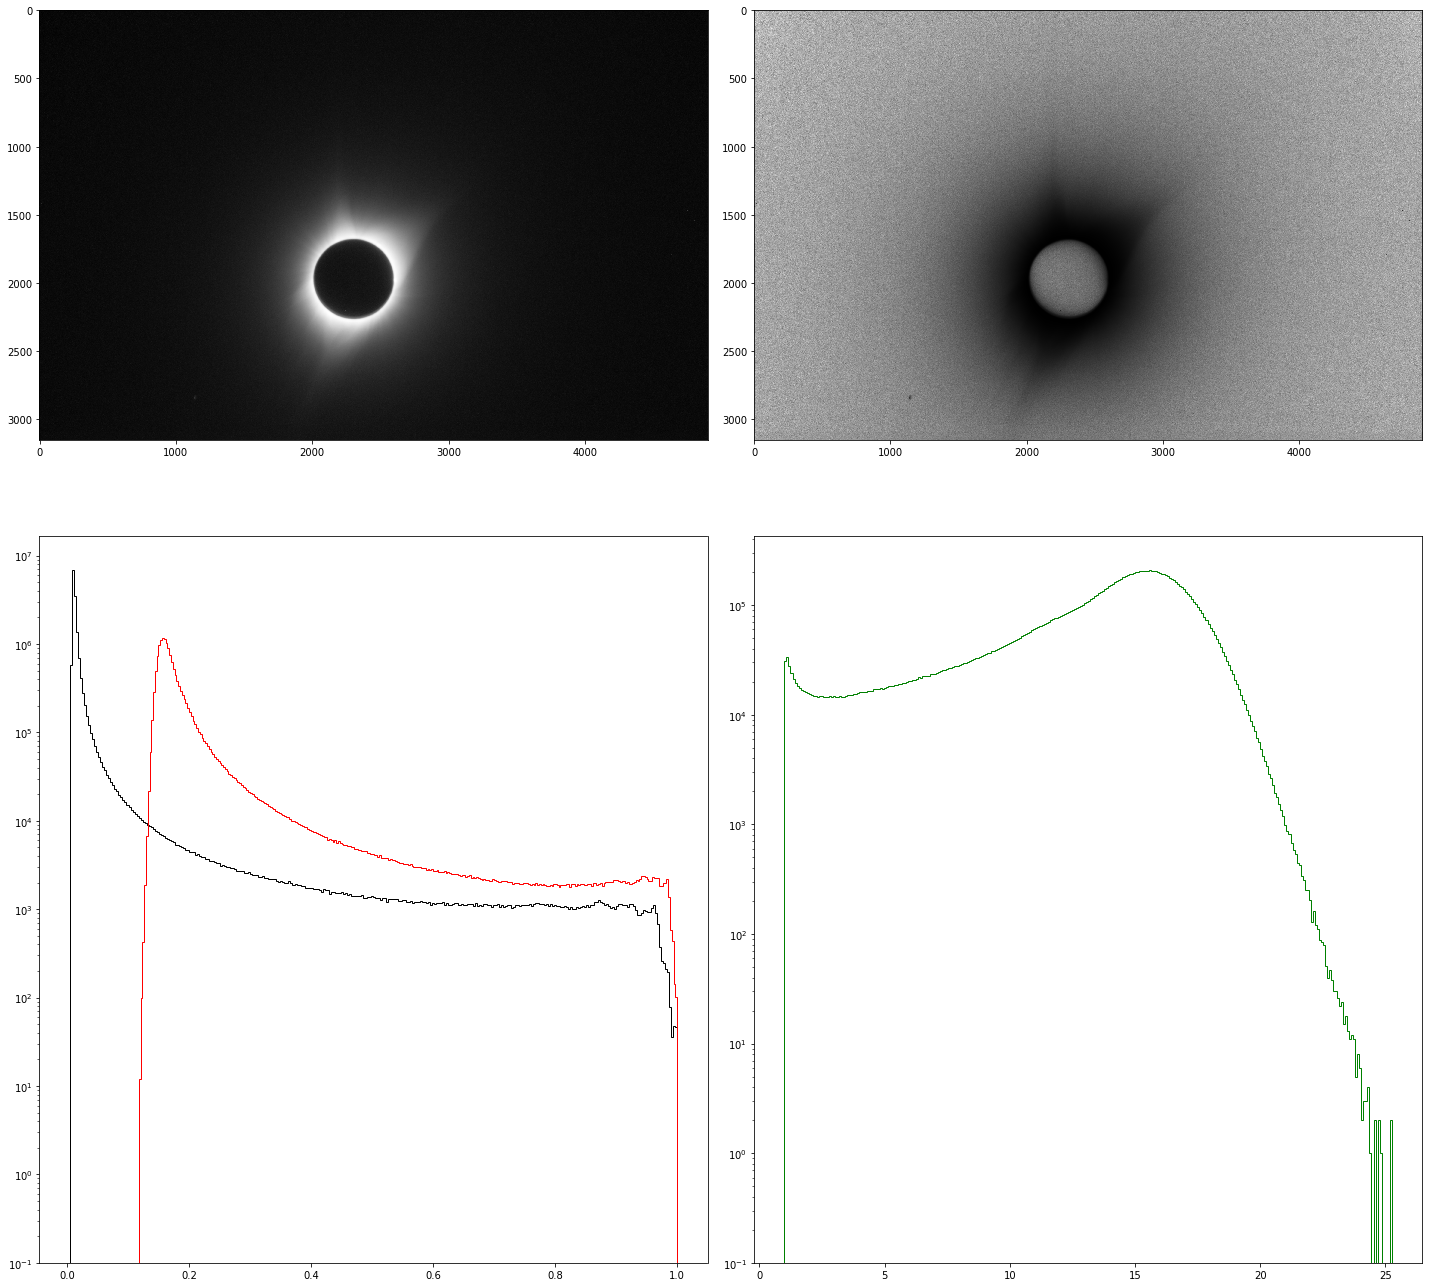

In [108]:
scale_grey = 0.5*((grey_norm)**(1/3)+(grey_norm)**(1/2))
# scale_grey = L
G_px = scale_grey/grey_norm
fig=plt.figure(figsize=(20,20))
plt.subplot(221)
plt.imshow(scale_grey)
plt.subplot(223)
plt.hist(np.ndarray.flatten(grey_norm),300,histtype='step',log=True,color='black')
plt.hist(np.ndarray.flatten(scale_grey),300,histtype='step',log=True,color='red')
plt.subplot(224)
plt.hist(np.ndarray.flatten(G_px),300,histtype='step',log=True,color='green')
plt.subplot(222)
plt.imshow(G_px)
fig.tight_layout()
plt.show()

In [45]:
timestamp = np.int(time.time())
master_out = np.int_((2**8-1)*master_img/master_level)
vips_encoding = np_to_vips(master_display)
vips_encoding.write_to_file(out_root+"master_"+str(timestamp)+".jpg")